In [1]:
#import packages
import numpy as np
import pandas as pd
import sklearn.tree as skt
from sklearn import model_selection as skm
!pip install econml
import econml.grf as eg
import econml.dml as ed
import shap
import matplotlib.pyplot as plt
from econml.cate_interpreter import SingleTreePolicyInterpreter
from econml.cate_interpreter import SingleTreeCateInterpreter
from econml.dml import LinearDML
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#prepare the data and make it workable
dat_train=pd.read_csv('Training_set_advance.csv')
dat_train=dat_train.dropna()
train_lab=dat_train[dat_train['Treated_with_drugs']=='DX1']
train_lab=pd.concat([train_lab,dat_train[dat_train['Treated_with_drugs']=='DX2'],dat_train[dat_train['Treated_with_drugs']=='DX3'],dat_train[dat_train['Treated_with_drugs']=='DX4'],dat_train[dat_train['Treated_with_drugs']=='DX5']])
dat_train=train_lab
train_lab=dat_train['Treated_with_drugs']
dat_train=dat_train.drop(['Patient_mental_condition','Patient_Rural_Urban','Patient_ID','ID_Patient_Care_Situation','Treated_with_drugs'],axis=1)
smo=[]
for i in dat_train['Patient_Smoker']:
  if(i=="YES"):
    smo.append(1)
  else:
    smo.append(0)
dat_train['Patient_Smoker']=smo    

dat_test=pd.read_csv('Testing_set_advance.csv')
dat_test=dat_test.dropna()

test_lab=dat_test[dat_test['Treated_with_drugs']=='DX1']
test_lab=pd.concat([test_lab,dat_test[dat_test['Treated_with_drugs']=='DX2'],dat_test[dat_test['Treated_with_drugs']=='DX3'],dat_test[dat_test['Treated_with_drugs']=='DX4'],dat_test[dat_test['Treated_with_drugs']=='DX5']])
dat_test=test_lab

test_lab=dat_test['Treated_with_drugs']
dat_test=dat_test.drop(['Patient_mental_condition','Patient_Rural_Urban','Patient_ID','ID_Patient_Care_Situation','Treated_with_drugs'],axis=1)

smo=[]
for i in dat_test['Patient_Smoker']:
  if(i=="YES"):
    smo.append(1)
  else:
    smo.append(0)
dat_test['Patient_Smoker']=smo 

dat_test[dat_test['Diagnosed_Condition']==1]


,Diagnosed_Condition,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,A,B,C,D,E,F,Z,Number_of_prev_cond
2235,1,49,26.498189,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3716,1,37,19.228954,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
6036,1,45,29.157853,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0
6446,1,9,17.213816,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0
6727,1,11,25.571038,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6937,1,37,22.090975,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,4.0
9175,1,19,21.392116,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9266,1,12,28.757736,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
813,1,19,17.756715,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2220,1,57,26.734052,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [3]:
#switch treatments from string to numeric
t=[]
for i in train_lab:
  if(i=="DX1"):
    t.append(0)
  elif(i=='DX2'):
    t.append(1)
  elif(i=='DX3'):
    t.append(2)
  elif(i=='DX4'):
    t.append(3)
  elif(i=='DX5'):
    t.append(4)
dat_train.head()

,Diagnosed_Condition,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,A,B,C,D,E,F,Z,Number_of_prev_cond,Survived_1_year
13,22,18,22.490941,1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,1
96,47,0,25.633369,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
144,23,17,20.734572,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0
147,8,51,20.503405,1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,1
206,15,24,29.103329,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1


In [6]:
#create and fit the causal forest
cf2=ed.CausalForestDML()
cf2.fit(Y=dat_train['Survived_1_year'],T=t,X=dat_train.drop('Survived_1_year',axis=1))

In [7]:
#get feature importances
cf2.feature_importances()

array([2.64213826e-01, 1.61440888e-01, 4.92826073e-01, 4.31279013e-02,
       2.30841833e-03, 3.56017452e-03, 6.69434854e-03, 8.68259108e-03,
       5.89275089e-03, 4.45561715e-05, 0.00000000e+00, 1.12084723e-02])

In [8]:
#shap values
sv=cf2.shap_values(dat_train.drop('Survived_1_year',axis=1))

100%|===================| 5064/5077 [01:35<00:00]       

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


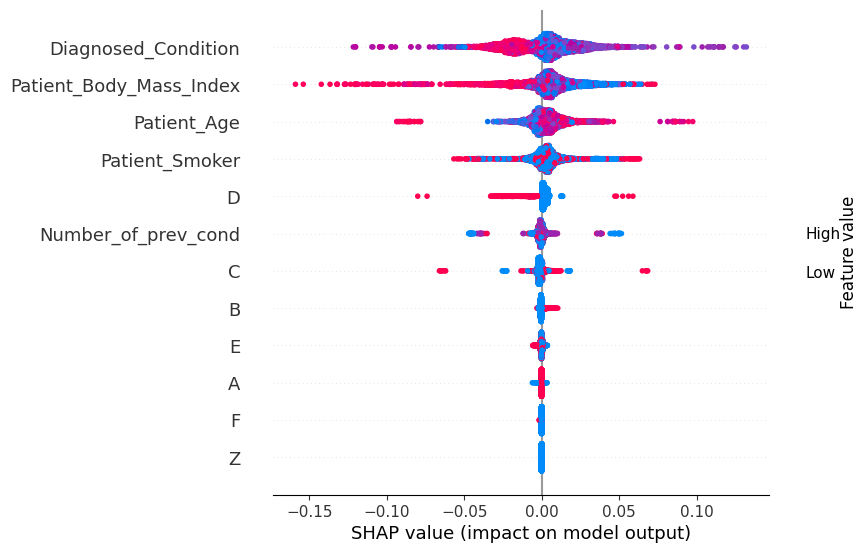

In [9]:
#shap graph
shap.summary_plot(sv['Survived_1_year']['T0'])

In [10]:
#cate + confidence intervals
ef=np.sort(cf2.effect(dat_train.drop('Survived_1_year',axis=1)))
lo,up=np.sort(cf2.effect_interval(dat_train.drop('Survived_1_year',axis=1),alpha=.05))

In [11]:
#rolling average to make data cleaner
np.shape(ef)
ef=pd.DataFrame(np.reshape(ef,(5077,1)),columns=['ef'])
ef=ef.rolling(15).mean()
lo=pd.DataFrame(np.reshape(lo,(5077,1)),columns=['lo'])
lo=lo.rolling(15).mean()
up=pd.DataFrame(np.reshape(up,(5077,1)),columns=['up'])
up=up.rolling(15).mean()


Text(0, 0.5, 'CATE')

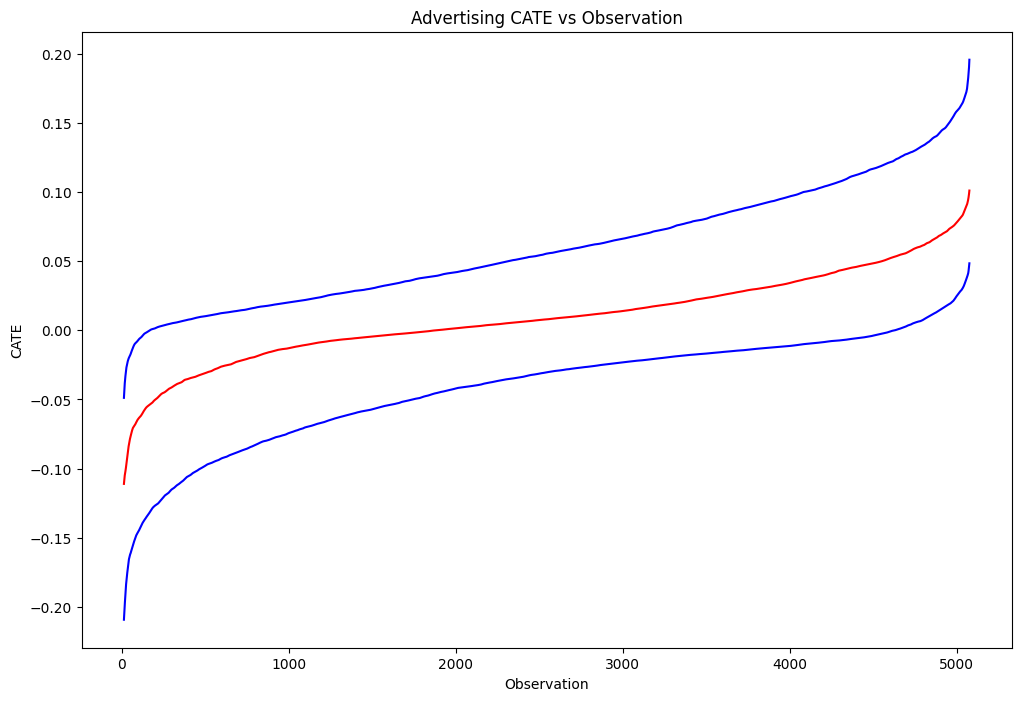

In [12]:
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(ef,color='red')
ax.plot(lo,color='blue')
ax.plot(up,color='blue')
plt.title("Advertising CATE vs Observation")
plt.xlabel("Observation")
plt.ylabel("CATE")

In [37]:
#advertising data
dat=pd.read_csv('WA_Marketing-Campaign.csv')
d2=dat[dat['Promotion']==3]
d1=dat[dat['Promotion']==2]
dat=pd.concat([d1,d2])
dat

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
4,1,Medium,2,5,2,1,27.81
5,1,Medium,2,5,2,2,34.67
6,1,Medium,2,5,2,3,27.98
7,1,Medium,2,5,2,4,27.72
12,1,Medium,4,1,2,1,39.28
...,...,...,...,...,...,...,...
487,10,Large,905,2,3,4,58.33
532,10,Large,917,14,3,1,53.50
533,10,Large,917,14,3,2,56.34
534,10,Large,917,14,3,3,51.83


In [38]:
#change market size to int
m=[]
for i in dat["MarketSize"]:
  if i=='Medium':
    m.append(1)
  elif i=='Small':
    m.append(0)
  else:
    m.append(2)
dat['MarketSize']=m


In [39]:
#create and fit forest
cf3=ed.CausalForestDML()
cf3.fit(Y=dat['SalesInThousands'],T=dat['Promotion'],X=dat.drop(['Promotion','SalesInThousands'],axis=1))

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009586354824225651, tolerance: 0.003749333333333332
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06329339944478463, tolerance: 0.003749333333333332
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12704762416145954, tolerance: 0.003749333333333332
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03195849440422904, tolerance: 0.0034092715231788073


In [40]:
#shap values
sv=cf3.shap_values(dat.drop(['Promotion','SalesInThousands'],axis=1))

In [41]:
#CATE and confidence
ef=np.sort(cf3.effect(dat.drop(['Promotion','SalesInThousands'],axis=1)))
lo,up=np.sort(cf3.effect_interval(dat.drop(['Promotion','SalesInThousands'],axis=1),alpha=.05))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


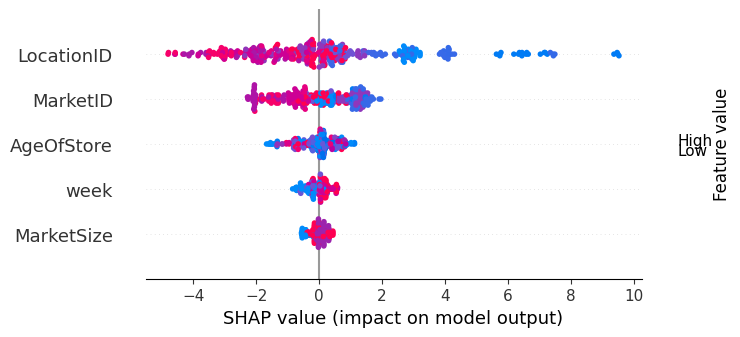

In [42]:
shap.summary_plot(sv['SalesInThousands']['Promotion'])

In [44]:
#Rolling average for cleaner data
np.shape(ef)
ef=pd.DataFrame(np.reshape(ef,(376,1)),columns=['ef'])
ef=ef.rolling(10).mean()
lo=pd.DataFrame(np.reshape(lo,(376,1)),columns=['lo'])
lo=lo.rolling(10).mean()
up=pd.DataFrame(np.reshape(up,(376,1)),columns=['up'])
up=up.rolling(10).mean()

Text(0, 0.5, 'CATE')

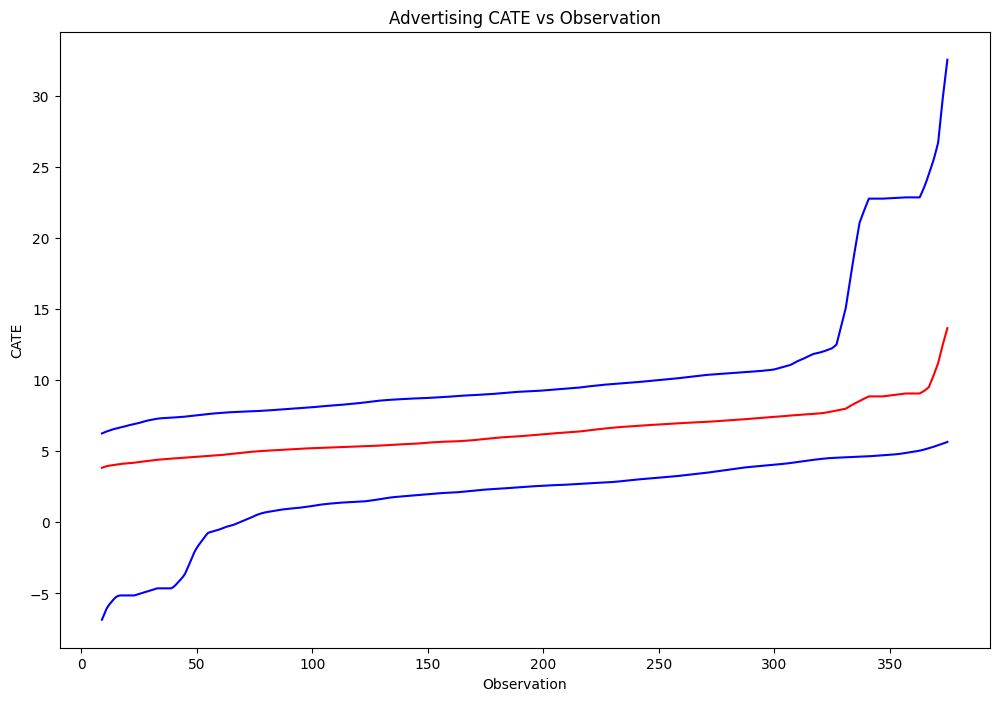

In [45]:
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(ef,color='red')
ax.plot(lo,color='blue')
ax.plot(up,color='blue')
plt.title("Advertising CATE vs Observation")
plt.xlabel("Observation")
plt.ylabel("CATE")

In [21]:
#feature importances
cf3.feature_importances()

array([0.21956311, 0.04502307, 0.55218535, 0.13315295, 0.05007552])

In [65]:
#Create estimator for interpretor
est=LinearDML()
est.fit(Y=dat['SalesInThousands'],T=dat['Promotion'],X=dat.drop(['Promotion','SalesInThousands'],axis=1))

In [66]:
#interpretor set up
intrp=SingleTreeCateInterpreter(include_model_uncertainty=True,max_depth=2,min_samples_leaf=10)

In [67]:
#interpretor
intrp.interpret(est,dat.drop(['Promotion','SalesInThousands'],axis=1))

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
X has feature names, but FunctionTransformer was fitted without feature names
X has feature names, but FunctionTransformer was fitted without feature names
X has feature names, but FunctionTransformer was fitted without feature names
X has feature names, but FunctionTransformer was fitted without feature names
X has feature names, but FunctionTransformer was fitted without feature names
X has feature names, but FunctionTransformer was fitted without feature names
X has feature names, but FunctionTransformer was fitted without feature names
X has feature names, but FunctionTransformer was fitted without feature names


In [68]:
#structure of tree
plt.figure(figsize=(25,5))
intrp.plot(feature_names=['MarketID','MarketSize','LocationID','AgeOfStore','week'],fontsize=12)
plt.savefig('fig.png')

In [70]:
#risk graph
intrp=SingleTreePolicyInterpreter(risk_level=None,max_depth=2,min_samples_leaf=1,min_impurity_decrease=.001)
intrp.interpret(est,dat.drop(['Promotion','SalesInThousands'],axis=1),sample_treatment_costs=.02)
plt.figure(figsize=(25,5))
intrp.plot(feature_names=['MarketID','MarketSize','LocationID','AgeOfStore','week'],fontsize=12)
plt.savefig('fig2.png')